# Sentiment Analysis Research and Application
## LSTM with word level tokenization
## by raja batra and eli rejto

This notebook goes over the process of preprocessing the sentiment 140 dataset with 1.6 million labeled tweets. Then we build an LSTM model and train the model using word level tokenization to predict the sentiment of tweets. The preprocessing of the data is the same process as the notebook with the transformer trained on word level tokenized data

In [1]:
import torch
import re
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from torch import nn, optim
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import torchtext
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn.utils.rnn import pad_sequence
from torch.nn.functional import one_hot
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## The data we are using is Sentiment 140 from kaggle: https://www.kaggle.com/datasets/kazanova/sentiment140

In [4]:
 csvfile = '/content/drive/MyDrive/twitter.csv'

In [5]:

DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

dataset = pd.read_csv(csvfile,
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

In [6]:
# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

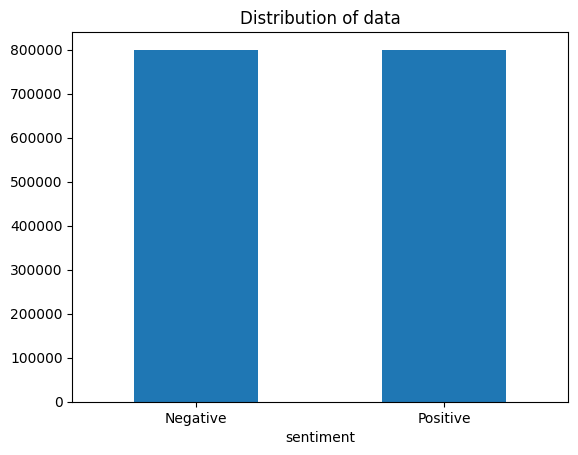

In [7]:
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

This preprocesses our data. It replaces URLs, Emojis, usernames, non alphabets or numbers, lowercases text, removes stop words, and lemmatizes text

In [8]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
def preprocess(textdata):
    processedText = []


    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))
    for tweet in textdata:


        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)

        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        tweet = tweet.lower()

        words = tweet.split()
        #lemantize words
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]


        processed_tweet = ' '.join(lemmatized_words)



        processedText.append(processed_tweet)

    return processedText

In [9]:
import time
t = time.time()
text, sentiment = list(dataset['text']), list(dataset['sentiment'])
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 109 seconds


Here is an example of before and after we process the text:

In [10]:
print(text[100])

 Body Of Missing Northern Calif. Girl Found: Police have found the remains of a missing Northern California girl .. http://tr.im/imji


In [11]:
print(processedtext[100])

body missing northern calif girl found police found remains missing northern california girl url


In [12]:
print(text[0])

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D


In [13]:
print(processedtext[0])

user url aww bummer shoulda got david carr third day


Next we build our vocabulary using torchtexts vocab function

In [14]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')
train_iter = [(label, text) for label, text in enumerate(processedtext)]

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

# Build the vocabulary based on the training data
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"], max_tokens=
                                  10000)
vocab.set_default_index(vocab["<unk>"])

In [15]:
print(list(vocab.get_stoi().keys())[1349])
word_index = vocab.get_stoi()['lakers']
print(f"Index of 'lakers': {word_index}")
print(len(vocab))

honeymoon
Index of 'lakers': 900
10000


Now we build our dataset

In [16]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, vocab, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.vocab = vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data[index]
        label = self.labels[index]

        # Convert text to numerical indices using the vocabulary
        numerical_indices = [self.vocab[word] for word in text]
        numerical_indices =torch.as_tensor(numerical_indices, dtype=torch.long)

        # Convert label to one-hot encoding
        one_hot_label = one_hot(torch.as_tensor(label, dtype=torch.long), num_classes=2)

        sample = {'data': numerical_indices, 'label': one_hot_label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [17]:
twitterdataset = CustomDataset(data=processedtext, labels=sentiment, vocab = vocab)

here we split the dataset into training test and validation

In [18]:
data = twitterdataset.data
labels = twitterdataset.labels


train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, stratify=labels, random_state=42
)

# Further split the test set into validation and test sets
validation_data, test_data, validation_labels, test_labels = train_test_split(
    test_data, test_labels, test_size=0.5, stratify=test_labels, random_state=42
)

In [19]:
print(train_data[10])

home throat killing need cook work clean shower apply internship busy busy


In [20]:
print(train_labels[10])

0


This pads our data

In [21]:
def collate_fn(batch):
    data = [torch.tensor(item['data']) for item in batch]
    label = [item['label'] for item in batch]

    # Pad sequences to the length of the longest sequence in the batch
    data_padded = pad_sequence(data, batch_first=True, padding_value=0)

    # Stack one-hot encoded labels
    label_stacked = torch.stack(label, dim=0)

    return {'data': data_padded, 'label': label_stacked}

This build the train test and validation dataloaders

In [22]:
from torch.utils.data import DataLoader

batch_size = 128

train_dataset = CustomDataset(train_data, train_labels, vocab)
validation_dataset = CustomDataset(validation_data, validation_labels, vocab)
test_dataset = CustomDataset(test_data, test_labels, vocab)

# Calculate the number of samples to use (20% of the dataset)
trainnum_samples = int(0.2 * len(train_dataset))
valnum_samples = int(0.2 * len(validation_dataset))
testnum_samples = int(0.2 * len(test_dataset))

# Create indices for the subset
trainindices = torch.randperm(len(train_dataset))[:trainnum_samples]
valindices = torch.randperm(len(validation_dataset))[:valnum_samples]
testindices = torch.randperm(len(test_dataset))[:testnum_samples]

# Create a SubsetRandomSampler using the indices
trainsubset_sampler = SubsetRandomSampler(trainindices)
valsubset_sampler = SubsetRandomSampler(valindices)
testsubset_sampler = SubsetRandomSampler(testindices)



# Create DataLoader instances for training, validation, and test sets
#shuffle is false since randomly taking subsets of data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, sampler=trainsubset_sampler)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, sampler=valsubset_sampler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, sampler=testsubset_sampler)

In [23]:
num_batches = len(train_loader)

print(f"Number of batches in the DataLoader: {num_batches}")

Number of batches in the DataLoader: 2000


In [24]:
for batch in validation_loader:
    # Access data and labels from the batch
    data_batch = batch['data']
    label_batch = batch['label']

    # Print a couple of samples from the batch
    for i in range(min(2, len(data_batch))):  # Print at most 2 samples
        print("Sample {}: ".format(i + 1))
        print("Data (Mapped to Integers):", data_batch[i])
        print("Label (One-Hot Encoding):", label_batch[i])

    # Break the loop after the first batch for demonstration purposes
    break

Sample 1: 
Data (Mapped to Integers): tensor([ 188, 1624,  188,    0,  736, 5941,  147,    0,  505,  505,    0,    0,
         736, 1624,    9,  147, 3158,    0,  736, 5941,  505, 1389,    0, 4193,
        6949,    0,  147, 3158,    0, 4193, 6949,    0,  222,    0,  640,  452,
        5941,  222,    0,    0,  640,  147, 5941,  623,  966, 6949,  505,  452,
           0,    0, 6949,  966, 1624,    9,  623,  966, 6949,    0, 5941, 1389,
         244, 1624, 4193, 4193, 5941,  220,  505,  452,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
Label (One-Hot Encoding): tensor([0, 1])
Sample 2: 
Data (Mapped to Integers): tensor([ 188, 1624,  147, 3158,  452,  222, 5941,  147,  623,    0,  322,    0,
        1389,  452,    0,  244,    9, 6949, 6949, 5941,  147,  623,    0,  736,
         222, 1624,  147, 6949,    0,  244,  966, 

<ipython-input-21-a1a8fb0b13a9>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = [torch.tensor(item['data']) for item in batch]


#LSTM Model

In [25]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [44]:
#using model based on https://www.kaggle.com/code/arunmohan003/sentiment-analysis-using-lstm-pytorch
class SentimentClassifier(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim, output_dim, drop_prob=0.5):
        super(SentimentClassifier,self).__init__()


        self.hidden_dim = hidden_dim
        self.no_layers = no_layers
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)

        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # dropout and fully connected layer
        out = self.fc(lstm_out)

        # sigmoid function
        # get last batch of labels
        sig_out = self.sig(out).view(batch_size, -1)[:, -1]

        # return last sigmoid output and hidden state
        return sig_out, hidden



    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)

        hidden = (h0,c0)
        return hidden


In [46]:

def trainRNN(lr, epochs, clip, layers, embedding_dim = 64, numclasses = 1, hidden_dim = 64):
  t = time.time()
  no_layers = layers
  vocab_size = len(vocab)
  embedding_dim = embedding_dim
  output_dim = numclasses
  hidden_dim = hidden_dim
  clip = 5


  modeltest = SentimentClassifier(no_layers,vocab_size,hidden_dim,embedding_dim, output_dim, drop_prob=0.5).to(device)



  criterion = nn.BCELoss()

  optimizer = torch.optim.Adam(modeltest.parameters(), lr=lr)

  valid_loss_min = np.Inf
  # train for some number of epochs
  epoch_tr_loss,epoch_vl_loss = [],[]
  epoch_tr_acc,epoch_vl_acc = [],[]

  for epoch in range(epochs):
      train_losses = []
      train_acc = 0.0
      modeltest.train()
      # initialize hidden state
      h = modeltest.init_hidden(batch_size)

      for batch in train_loader:

          inputs = batch['data'].to(device)

          targets = batch['label'].to(device)
          targets = targets.type(torch.FloatTensor)

          targets = torch.argmax(targets, dim=1)
          labels = targets
          labels = labels.to(device)

          # Creating new variables for the hidden state
          h = tuple([each.data for each in h])

          modeltest.zero_grad()
          output,h = modeltest(inputs,h)

          # calculate the loss and perform backprop
          loss = criterion(output.squeeze(), labels.float())
          loss.backward()
          train_losses.append(loss.item())
          # calculating accuracy
          accuracy = acc(output,labels)
          train_acc += accuracy

          #`clip_grad_norm` helps prevent the exploding gradient problem
          nn.utils.clip_grad_norm_(modeltest.parameters(), clip)
          optimizer.step()



      val_h = modeltest.init_hidden(batch_size)
      val_losses = []
      val_acc = 0.0
      modeltest.eval()
      for batch in validation_loader:
              val_h = tuple([each.data for each in val_h])


              inputs = batch['data'].to(device)

              targets = batch['label'].to(device)
              targets = targets.type(torch.FloatTensor)

              targets = torch.argmax(targets, dim=1)
              labels = targets
              labels = labels.to(device)

              output, val_h = modeltest(inputs, val_h)

              val_loss = criterion(output.squeeze(), labels.float())

              val_losses.append(val_loss.item())

              accuracy = acc(output,labels)
              val_acc += accuracy

      epoch_train_loss = np.mean(train_losses)
      epoch_val_loss = np.mean(val_losses)
      epoch_train_acc = train_acc/len(train_losses)
      epoch_val_acc = val_acc/len(val_losses)
      epoch_tr_loss.append(epoch_train_loss)
      epoch_vl_loss.append(epoch_val_loss)
      epoch_tr_acc.append(epoch_train_acc)
      epoch_vl_acc.append(epoch_val_acc)
      # Print the training and validation metrics for the current epoch
      print(f'Epoch [{epoch + 1}/{epochs}] - '
            f'Train Loss: {epoch_train_loss*100:.4f} - '
            f'Validation Loss: {epoch_val_loss*100:.4f} - '
            f'Validation Accuracy: {epoch_val_acc*100:.2f}%')
      print(f'Time Taken: {round(time.time()-t)} seconds')
  losses = (epoch_tr_loss, epoch_vl_loss, epoch_vl_acc)
  return (losses, modeltest)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()/len(pred)


In [47]:
def plot_losses(losses):
    train_losses,val_losses,val_accuracies = losses
    epochs = range(1, len(train_losses) + 1)


    plt.plot(epochs, train_losses, label='Training Loss', marker='o', linestyle='-', color='b')


    plt.plot(epochs, val_losses, label='Validation Loss', marker='o', linestyle='-', color='r')


    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss Curves')
    plt.legend()


    plt.show()

This was the best model that we trained taking around 793 seconds to train 20 epochs and seeing a validation accuracy of around 74 percent

<ipython-input-21-a1a8fb0b13a9>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = [torch.tensor(item['data']) for item in batch]


Epoch [1/20] - Train Loss: 69.3244 - Validation Loss: 69.3157 - Validation Accuracy: 50.23%
Time Taken: 40 seconds
Epoch [2/20] - Train Loss: 69.2787 - Validation Loss: 68.6804 - Validation Accuracy: 54.62%
Time Taken: 78 seconds
Epoch [3/20] - Train Loss: 63.0307 - Validation Loss: 59.5350 - Validation Accuracy: 68.10%
Time Taken: 119 seconds
Epoch [4/20] - Train Loss: 58.3626 - Validation Loss: 57.2343 - Validation Accuracy: 70.06%
Time Taken: 158 seconds
Epoch [5/20] - Train Loss: 56.5639 - Validation Loss: 56.0154 - Validation Accuracy: 71.11%
Time Taken: 198 seconds
Epoch [6/20] - Train Loss: 55.5006 - Validation Loss: 55.0807 - Validation Accuracy: 71.66%
Time Taken: 237 seconds
Epoch [7/20] - Train Loss: 54.6678 - Validation Loss: 54.9360 - Validation Accuracy: 71.58%
Time Taken: 275 seconds
Epoch [8/20] - Train Loss: 54.0509 - Validation Loss: 54.0275 - Validation Accuracy: 72.57%
Time Taken: 315 seconds
Epoch [9/20] - Train Loss: 53.5680 - Validation Loss: 55.5331 - Validation

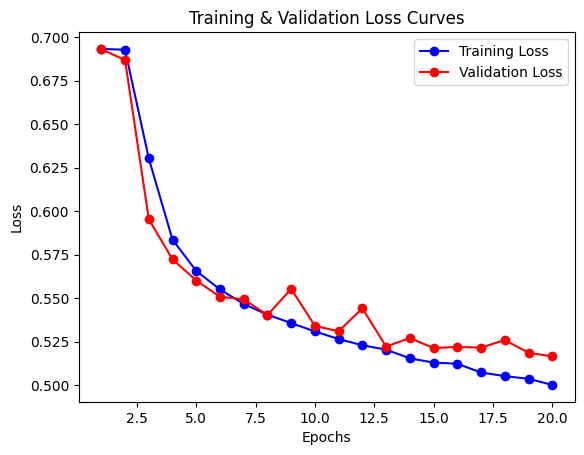

In [48]:
lr = 0.0005
epochs = 20
clip = 5
layers = 2
embedding_dim = 256
hidden_dim = 512

losses,finalmodel = trainRNN(lr, epochs, clip, layers, embedding_dim, hidden_dim)
plot_losses(losses)

I will now test this model with my test dataset to see the accuracy of data that was not seen during training. The test accuracy was also around 74 percent

In [55]:
finalmodel.eval()

# Assuming you have a DataLoader for the test dataset, named test_loader
# test_loader = ...

correct = 0
total = 0
val_h = finalmodel.init_hidden(batch_size)

# Iterate through the test dataset
with torch.no_grad():  # Disable gradient computation during inference
    for batch in test_loader:
        val_h = tuple([each.data for each in val_h])

        #inputs, labels = inputs.to(device), labels.to(device)
        inputs = batch['data'].to(device)
        #print(inputs)
        targets = batch['label'].to(device)
        targets = targets.type(torch.FloatTensor)

        targets = torch.argmax(targets, dim=1)
        labels = targets
        labels = labels.to(device)
        #print(labels)
        output, val_h = finalmodel(inputs, val_h)
        #print(output)


        accuracy = acc(output,labels)
        correct += accuracy
        total+=1



# Compute accuracy
test_accuracy = correct / total

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

<ipython-input-21-a1a8fb0b13a9>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = [torch.tensor(item['data']) for item in batch]


Test Accuracy: 73.76%


Here is another model we tried that was larger in size

<ipython-input-21-a1a8fb0b13a9>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = [torch.tensor(item['data']) for item in batch]


Epoch [1/10] - Train Loss: 68.3595 - Validation Loss: 67.2524 - Validation Accuracy: 58.18%
Time Taken: 46 seconds
Epoch [2/10] - Train Loss: 66.3030 - Validation Loss: 65.1161 - Validation Accuracy: 60.88%
Time Taken: 95 seconds
Epoch [3/10] - Train Loss: 64.0453 - Validation Loss: 62.7673 - Validation Accuracy: 64.75%
Time Taken: 142 seconds
Epoch [4/10] - Train Loss: 61.8182 - Validation Loss: 61.3414 - Validation Accuracy: 65.94%
Time Taken: 187 seconds
Epoch [5/10] - Train Loss: 60.1214 - Validation Loss: 60.4763 - Validation Accuracy: 67.36%
Time Taken: 233 seconds
Epoch [6/10] - Train Loss: 59.0204 - Validation Loss: 59.3836 - Validation Accuracy: 68.03%
Time Taken: 279 seconds
Epoch [7/10] - Train Loss: 58.1245 - Validation Loss: 57.8271 - Validation Accuracy: 69.33%
Time Taken: 325 seconds
Epoch [8/10] - Train Loss: 57.3108 - Validation Loss: 57.2215 - Validation Accuracy: 70.13%
Time Taken: 372 seconds
Epoch [9/10] - Train Loss: 56.7058 - Validation Loss: 56.0898 - Validation

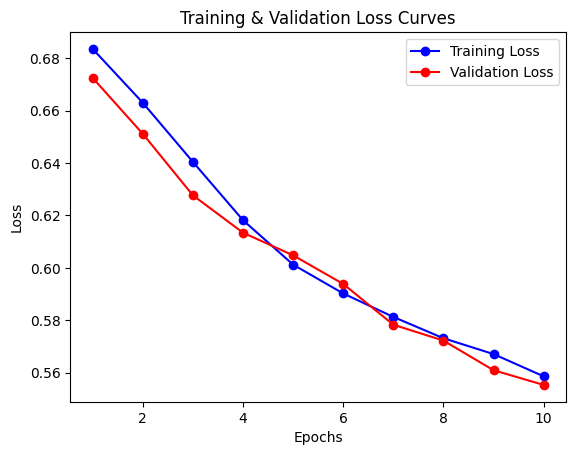

In [56]:
lr = 0.0007
epochs = 10
clip = 5
layers = 2
embedding_dim = 512
hidden_dim = 1048

losses,finalmodel2 = trainRNN(lr, epochs, clip, layers, embedding_dim, hidden_dim)
plot_losses(losses)